### Import Libraries

In [1]:
# !pip install git+https://github.com/tensorflow/examples.git
# !pip install keras
# !pip install matplotlib-inline
# !pip install pandas
# !pip install Pillow
# !pip install tensorflow
# !pip install tensorflow-datasets
# !pip install tqdm

In [2]:
from dataset import *
from model import *
from train import *
from inference import *

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
2023-12-15 23:46:02.257076: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
2023-12-15 23:46:03.002326: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat

## Load Dataset

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
2023-12-15 23:46:03.866164: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


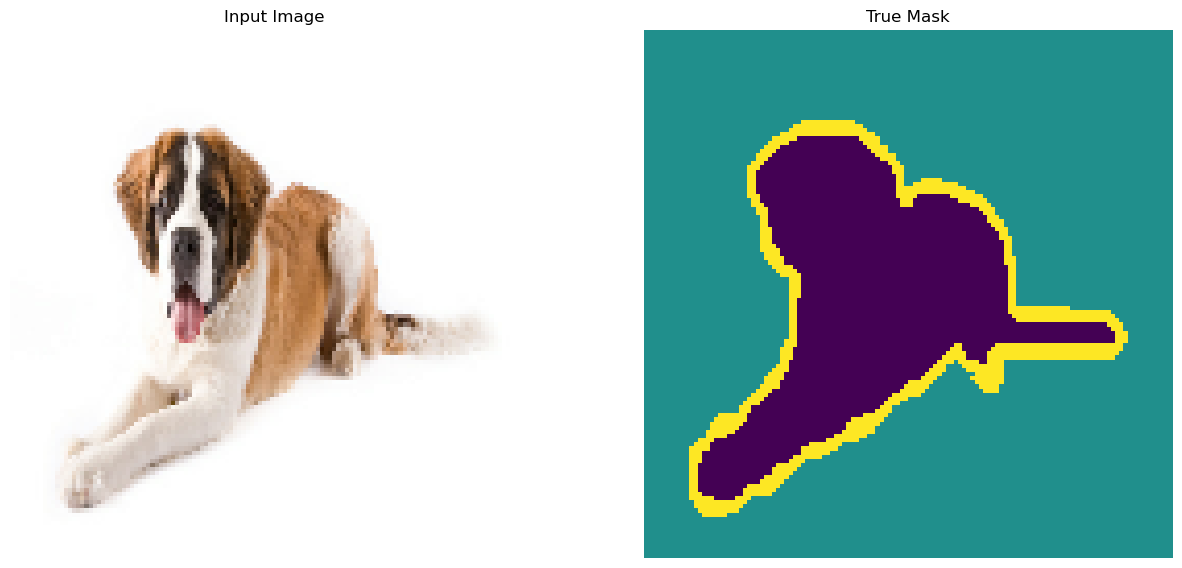

In [3]:
train_batches, test_batches, info, sample_image, sample_mask = get_dataset()
display([sample_image, sample_mask])

## Model.py


In [4]:
output_classes = 3

model = unet_model(output_channels=output_classes)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [5]:
# tf.keras.utils.plot_model(model, show_shapes=True)
from IPython.display import Image, display
display(Image(url='model_architecture.png'))

## Train.py

1/1 [==============================] - 0s 396ms/step


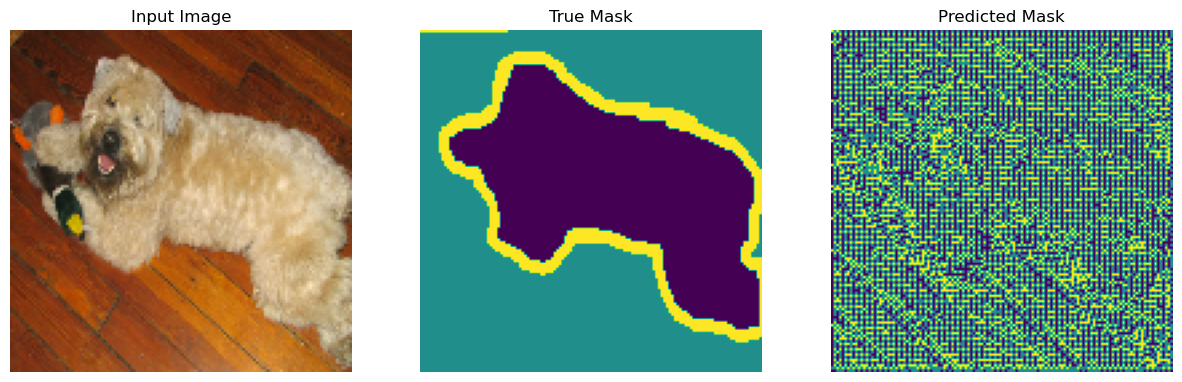

In [6]:
# Not trained example
show_predictions()

1/1 [==============================] - 0s 23ms/step


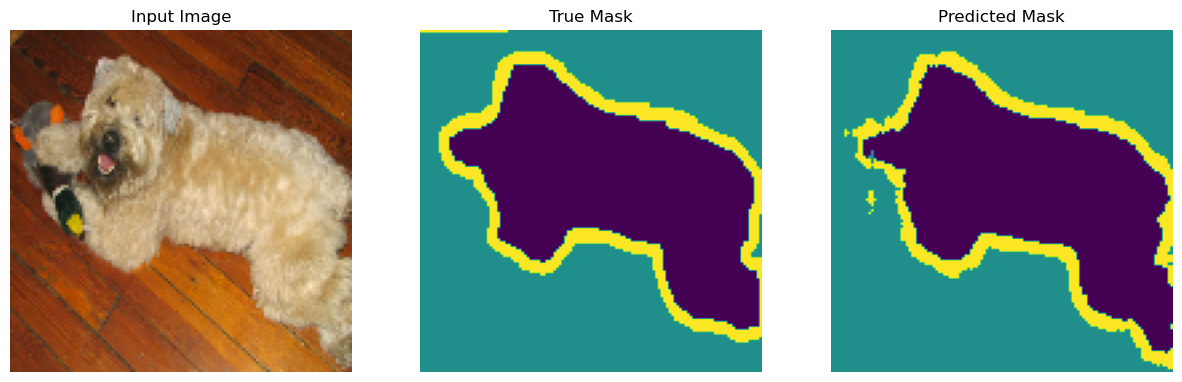


Sample Prediction after epoch 20

57/57 [==============================] - 77s 1s/step - loss: 0.1725 - accuracy: 0.9296 - val_loss: 0.2678 - val_accuracy: 0.9057


In [7]:
model_history = train()

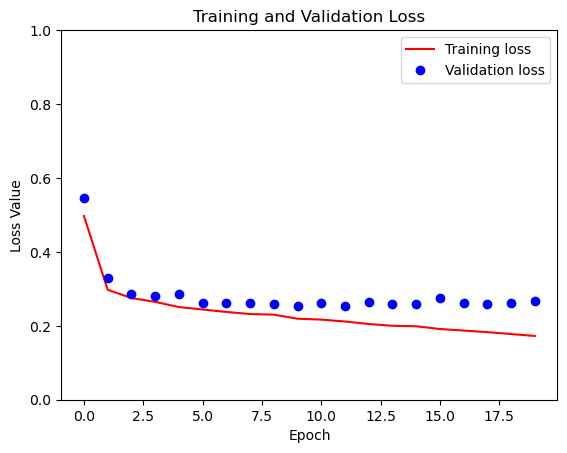

In [8]:
visualize_loss(model_history)

## Inference.py

In [9]:
make_predictions(test_batches)

2/2 [==============================] - 0s 252ms/step


2/2 [==============================] - 1s 263ms/step


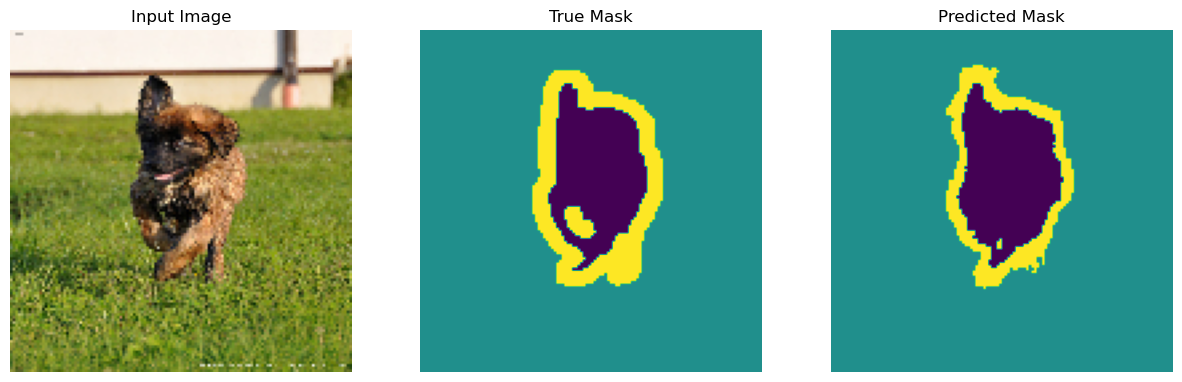

2/2 [==============================] - 1s 268ms/step


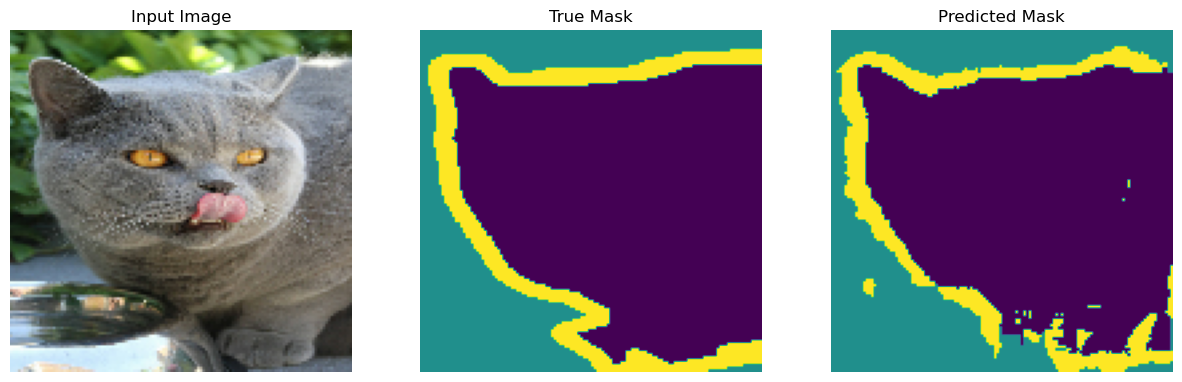

2/2 [==============================] - 1s 259ms/step


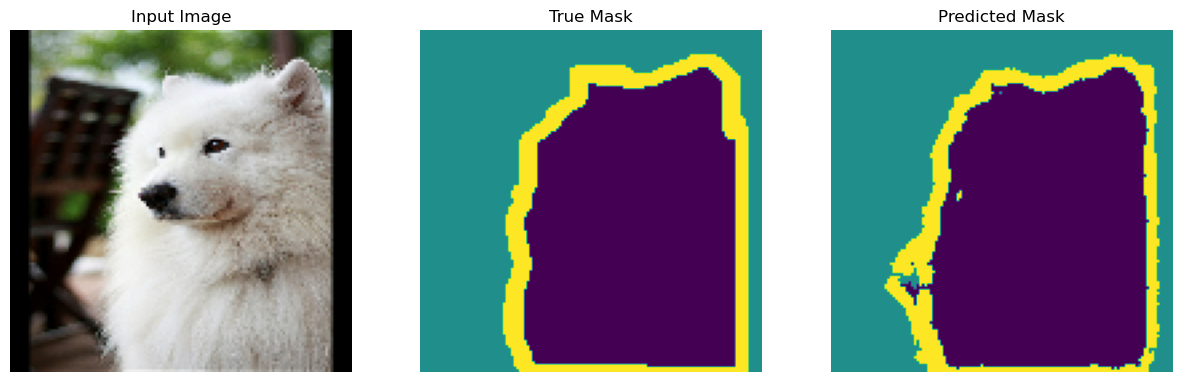

In [10]:
show_predictions(test_batches, 3)